In [13]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


In [14]:
class LlamaMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LlamaMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim * 4)  # 上采样，通常放大 4 倍
        self.activation = nn.GELU()                      # 使用 GELU 激活
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim) # 下采样，恢复到 hidden_dim

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [15]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [16]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_decoding = [entry['output'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_decoding = [entry['output'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement, non_infringement_decoding, infringement_decoding

In [17]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = LlamaMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement, non_infringement_decoding, infringement_decoding = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


In [19]:


# def cut_text_by_remaining(text, remaining_length):
#     if remaining_length >= len(text):
#         return "" 
#     else:
#         return text[:-remaining_length]

# non_infringement_decoding = cut_text_by_remaining(non_infringement_decoding,10)
# infringement_decoding = cut_text_by_remaining(infringement_decoding,10)

In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
X_non_infringement_decoding = extract_hidden_states(non_infringement_decoding, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, X_non_infringement_decoding, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
X_infringement_decoding = extract_hidden_states(infringement_decoding, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, X_infringement_decoding, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [02:53<00:00,  1.34it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:04<00:00, 47.78it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [02:59<00:00,  1.35it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:03<00:00, 78.19it/s]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epochs:   1%|          | 19/2500 [00:00<00:42, 58.40it/s]

Epoch 10/2500, Loss: 0.4721
Test Accuracy at Epoch 10: 64.47%
Test F1-score at Epoch 10: 0.7007
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.76      0.45      0.56       194
non_infringement       0.60      0.85      0.70       186

        accuracy                           0.64       380
       macro avg       0.68      0.65      0.63       380
    weighted avg       0.68      0.64      0.63       380

New best model saved with F1-score 0.7007 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.76      0.45      0.56       194
non_infringement       0.60      0.85      0.70       186

        accuracy                           0.64       380
       macro avg       0.68      0.65      0.63       380
    weighted avg       0.68      0.64      0.63       380

Epoch 20/2500, Loss: 0.3389
Test Accuracy at Epoch 20: 68.95%
Test F1-sco

Training Epochs:   1%|▏         | 37/2500 [00:00<00:33, 74.54it/s]

Epoch 30/2500, Loss: 0.2493
Test Accuracy at Epoch 30: 71.84%
Test F1-score at Epoch 30: 0.7470
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380

New best model saved with F1-score 0.7470 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380

Epoch 40/2500, Loss: 0.1882
Test Accuracy at Epoch 40: 73.68%
Test F1-sco

Training Epochs:   2%|▏         | 62/2500 [00:00<00:31, 76.80it/s]

Epoch 50/2500, Loss: 0.1438
Test Accuracy at Epoch 50: 73.95%
Test F1-score at Epoch 50: 0.7519
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-score 0.7519 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 60/2500, Loss: 0.1117
Test Accuracy at Epoch 60: 73.42%
Test F1-sco

Training Epochs:   3%|▎         | 80/2500 [00:01<00:31, 75.89it/s]

Epoch 70/2500, Loss: 0.0882
Test Accuracy at Epoch 70: 74.21%
Test F1-score at Epoch 70: 0.7500
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 80/2500, Loss: 0.0712
Test Accuracy at Epoch 80: 74.21%
Test F1-score at Epoch 80: 0.7500
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   4%|▍         | 100/2500 [00:01<00:28, 83.03it/s]

Epoch 90/2500, Loss: 0.0586
Test Accuracy at Epoch 90: 74.21%
Test F1-score at Epoch 90: 0.7487
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 100/2500, Loss: 0.0492
Test Accuracy at Epoch 100: 74.47%
Test F1-score at Epoch 100: 0.7519
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-sco

Training Epochs:   5%|▍         | 117/2500 [00:01<00:31, 74.63it/s]

Epoch 110/2500, Loss: 0.0420
Test Accuracy at Epoch 110: 74.74%
Test F1-score at Epoch 110: 0.7563
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

New best model saved with F1-score 0.7563 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 120/2500, Loss: 0.0364
Test Accuracy at Epoch 120: 74.74%
Tes

Training Epochs:   6%|▌         | 140/2500 [00:01<00:35, 66.36it/s]

Epoch 130/2500, Loss: 0.0320
Test Accuracy at Epoch 130: 75.00%
Test F1-score at Epoch 130: 0.7583
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

New best model saved with F1-score 0.7583 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 140/2500, Loss: 0.0285
Test Accuracy at Epoch 140: 75.00%
Tes

Training Epochs:   6%|▌         | 155/2500 [00:02<00:34, 67.82it/s]

Epoch 150/2500, Loss: 0.0256
Test Accuracy at Epoch 150: 74.74%
Test F1-score at Epoch 150: 0.7563
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   7%|▋         | 170/2500 [00:02<00:39, 59.65it/s]

Epoch 160/2500, Loss: 0.0233
Test Accuracy at Epoch 160: 74.74%
Test F1-score at Epoch 160: 0.7563
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 170/2500, Loss: 0.0213
Test Accuracy at Epoch 170: 74.74%
Test F1-score at Epoch 170: 0.7563
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   8%|▊         | 193/2500 [00:02<00:35, 65.12it/s]

Epoch 180/2500, Loss: 0.0196
Test Accuracy at Epoch 180: 75.53%
Test F1-score at Epoch 180: 0.7646
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

New best model saved with F1-score 0.7646 at epoch 180
Best Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 190/2500, Loss: 0.0182
Test Accuracy at Epoch 190: 75.53%
Tes

Training Epochs:   8%|▊         | 210/2500 [00:03<00:34, 65.52it/s]

Epoch 200/2500, Loss: 0.0171
Test Accuracy at Epoch 200: 75.53%
Test F1-score at Epoch 200: 0.7646
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 210/2500, Loss: 0.0160
Test Accuracy at Epoch 210: 75.26%
Test F1-score at Epoch 210: 0.7626
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   9%|▉         | 236/2500 [00:03<00:29, 76.14it/s]

Epoch 220/2500, Loss: 0.0152
Test Accuracy at Epoch 220: 75.53%
Test F1-score at Epoch 220: 0.7646
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 230/2500, Loss: 0.0144
Test Accuracy at Epoch 230: 75.53%
Test F1-score at Epoch 230: 0.7646
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  10%|█         | 252/2500 [00:03<00:30, 73.25it/s]

Epoch 240/2500, Loss: 0.0137
Test Accuracy at Epoch 240: 75.79%
Test F1-score at Epoch 240: 0.7677
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

New best model saved with F1-score 0.7677 at epoch 240
Best Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 250/2500, Loss: 0.0131
Test Accuracy at Epoch 250: 75.53%
Tes

Training Epochs:  11%|█         | 267/2500 [00:03<00:35, 62.87it/s]

Epoch 260/2500, Loss: 0.0126
Test Accuracy at Epoch 260: 75.53%
Test F1-score at Epoch 260: 0.7646
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 270/2500, Loss: 0.0121


Training Epochs:  11%|█▏        | 285/2500 [00:04<00:29, 74.07it/s]

Test Accuracy at Epoch 270: 75.26%
Test F1-score at Epoch 270: 0.7626
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 280/2500, Loss: 0.0117
Test Accuracy at Epoch 280: 75.26%
Test F1-score at Epoch 280: 0.7626
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  12%|█▏        | 293/2500 [00:04<00:32, 68.79it/s]

Epoch 290/2500, Loss: 0.0113
Test Accuracy at Epoch 290: 75.53%
Test F1-score at Epoch 290: 0.7646
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  12%|█▏        | 307/2500 [00:04<00:46, 46.80it/s]

Epoch 300/2500, Loss: 0.0109
Test Accuracy at Epoch 300: 75.53%
Test F1-score at Epoch 300: 0.7646
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 310/2500, Loss: 0.0106


Training Epochs:  13%|█▎        | 321/2500 [00:04<00:39, 55.08it/s]

Test Accuracy at Epoch 310: 75.53%
Test F1-score at Epoch 310: 0.7646
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 320/2500, Loss: 0.0103
Test Accuracy at Epoch 320: 75.26%
Test F1-score at Epoch 320: 0.7626
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  13%|█▎        | 336/2500 [00:05<00:39, 55.43it/s]

Epoch 330/2500, Loss: 0.0100
Test Accuracy at Epoch 330: 75.00%
Test F1-score at Epoch 330: 0.7595
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  14%|█▍        | 349/2500 [00:05<00:37, 57.61it/s]

Epoch 340/2500, Loss: 0.0098
Test Accuracy at Epoch 340: 75.00%
Test F1-score at Epoch 340: 0.7595
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 350/2500, Loss: 0.0096
Test Accuracy at Epoch 350: 75.00%
Test F1-score at Epoch 350: 0.7595


Training Epochs:  14%|█▍        | 361/2500 [00:05<00:40, 52.50it/s]

Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 360/2500, Loss: 0.0094
Test Accuracy at Epoch 360: 75.26%
Test F1-score at Epoch 360: 0.7614
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  15%|█▍        | 374/2500 [00:05<00:43, 48.68it/s]

Epoch 370/2500, Loss: 0.0092
Test Accuracy at Epoch 370: 75.26%
Test F1-score at Epoch 370: 0.7614
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  16%|█▌        | 390/2500 [00:06<00:34, 61.37it/s]

Epoch 380/2500, Loss: 0.0090
Test Accuracy at Epoch 380: 75.26%
Test F1-score at Epoch 380: 0.7614
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 390/2500, Loss: 0.0088
Test Accuracy at Epoch 390: 75.26%
Test F1-score at Epoch 390: 0.7614
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  17%|█▋        | 419/2500 [00:06<00:24, 84.30it/s]

Epoch 400/2500, Loss: 0.0087
Test Accuracy at Epoch 400: 75.26%
Test F1-score at Epoch 400: 0.7614
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 410/2500, Loss: 0.0085
Test Accuracy at Epoch 410: 75.26%
Test F1-score at Epoch 410: 0.7614
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 420/2500, Loss: 0.0084

Training Epochs:  18%|█▊        | 444/2500 [00:06<00:20, 100.25it/s]

Epoch 430/2500, Loss: 0.0083
Test Accuracy at Epoch 430: 75.00%
Test F1-score at Epoch 430: 0.7583
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 440/2500, Loss: 0.0082
Test Accuracy at Epoch 440: 75.00%
Test F1-score at Epoch 440: 0.7583
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 450/2500, Loss: 0.0080

Training Epochs:  19%|█▉        | 479/2500 [00:06<00:14, 136.79it/s]

Epoch 460/2500, Loss: 0.0079
Test Accuracy at Epoch 460: 75.00%
Test F1-score at Epoch 460: 0.7583
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 470/2500, Loss: 0.0078
Test Accuracy at Epoch 470: 75.00%
Test F1-score at Epoch 470: 0.7583
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 480/2500, Loss: 0.0078

Training Epochs:  21%|██        | 514/2500 [00:07<00:14, 141.15it/s]

Epoch 500/2500, Loss: 0.0076
Test Accuracy at Epoch 500: 75.00%
Test F1-score at Epoch 500: 0.7595
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 510/2500, Loss: 0.0075
Test Accuracy at Epoch 510: 75.00%
Test F1-score at Epoch 510: 0.7595
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 520/2500, Loss: 0.0074

Training Epochs:  22%|██▏       | 550/2500 [00:07<00:12, 156.77it/s]

Test Accuracy at Epoch 530: 75.26%
Test F1-score at Epoch 530: 0.7614
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 540/2500, Loss: 0.0073
Test Accuracy at Epoch 540: 75.00%
Test F1-score at Epoch 540: 0.7595
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 550/2500, Loss: 0.0072
Test Accuracy at Epoch 550: 

Training Epochs:  23%|██▎       | 585/2500 [00:07<00:13, 140.29it/s]

Epoch 570/2500, Loss: 0.0071
Test Accuracy at Epoch 570: 75.00%
Test F1-score at Epoch 570: 0.7595
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 580/2500, Loss: 0.0071
Test Accuracy at Epoch 580: 75.00%
Test F1-score at Epoch 580: 0.7595
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 590/2500, Loss: 0.0070

Training Epochs:  25%|██▍       | 617/2500 [00:07<00:12, 148.56it/s]

Epoch 600/2500, Loss: 0.0070
Test Accuracy at Epoch 600: 75.00%
Test F1-score at Epoch 600: 0.7595
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 610/2500, Loss: 0.0069
Test Accuracy at Epoch 610: 75.00%
Test F1-score at Epoch 610: 0.7595
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 620/2500, Loss: 0.0069

Training Epochs:  26%|██▌       | 650/2500 [00:07<00:12, 145.55it/s]

Epoch 630/2500, Loss: 0.0068
Test Accuracy at Epoch 630: 75.00%
Test F1-score at Epoch 630: 0.7595
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 640/2500, Loss: 0.0068
Test Accuracy at Epoch 640: 75.00%
Test F1-score at Epoch 640: 0.7595
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 650/2500, Loss: 0.0067

Training Epochs:  27%|██▋       | 687/2500 [00:08<00:12, 150.35it/s]

Epoch 670/2500, Loss: 0.0067
Test Accuracy at Epoch 670: 75.00%
Test F1-score at Epoch 670: 0.7595
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 680/2500, Loss: 0.0066
Test Accuracy at Epoch 680: 75.00%
Test F1-score at Epoch 680: 0.7595
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 690/2500, Loss: 0.0066

Training Epochs:  29%|██▉       | 725/2500 [00:08<00:10, 168.13it/s]

Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 710/2500, Loss: 0.0065
Test Accuracy at Epoch 710: 74.74%
Test F1-score at Epoch 710: 0.7576
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 720/2500, Loss: 0.0065
Test Accuracy at Epoch 720: 74.74%
Test F1-score at Epoch 720: 0.7576
Classification Report at Epo

Training Epochs:  30%|███       | 760/2500 [00:08<00:11, 151.07it/s]

Epoch 740/2500, Loss: 0.0064
Test Accuracy at Epoch 740: 74.74%
Test F1-score at Epoch 740: 0.7576
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 750/2500, Loss: 0.0064
Test Accuracy at Epoch 750: 74.74%
Test F1-score at Epoch 750: 0.7576
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 760/2500, Loss: 0.0064

Training Epochs:  32%|███▏      | 797/2500 [00:08<00:10, 165.57it/s]

Epoch 770/2500, Loss: 0.0063
Test Accuracy at Epoch 770: 74.74%
Test F1-score at Epoch 770: 0.7576
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 780/2500, Loss: 0.0063
Test Accuracy at Epoch 780: 75.26%
Test F1-score at Epoch 780: 0.7638
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 790/2500, Loss: 0.0063

Training Epochs:  33%|███▎      | 833/2500 [00:09<00:11, 151.16it/s]

Epoch 810/2500, Loss: 0.0062
Test Accuracy at Epoch 810: 75.26%
Test F1-score at Epoch 810: 0.7638
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 820/2500, Loss: 0.0062
Test Accuracy at Epoch 820: 75.26%
Test F1-score at Epoch 820: 0.7638
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 830/2500, Loss: 0.0062

Training Epochs:  35%|███▍      | 870/2500 [00:09<00:09, 163.79it/s]

Epoch 840/2500, Loss: 0.0062
Test Accuracy at Epoch 840: 75.26%
Test F1-score at Epoch 840: 0.7638
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 850/2500, Loss: 0.0061
Test Accuracy at Epoch 850: 75.26%
Test F1-score at Epoch 850: 0.7638
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 860/2500, Loss: 0.0061

Training Epochs:  36%|███▋      | 910/2500 [00:09<00:09, 175.45it/s]

Epoch 880/2500, Loss: 0.0061
Test Accuracy at Epoch 880: 75.26%
Test F1-score at Epoch 880: 0.7638
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 890/2500, Loss: 0.0061
Test Accuracy at Epoch 890: 75.26%
Test F1-score at Epoch 890: 0.7638
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 900/2500, Loss: 0.0060

Training Epochs:  38%|███▊      | 946/2500 [00:09<00:09, 169.40it/s]

Epoch 920/2500, Loss: 0.0060
Test Accuracy at Epoch 920: 75.26%
Test F1-score at Epoch 920: 0.7638
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 930/2500, Loss: 0.0060
Test Accuracy at Epoch 930: 75.26%
Test F1-score at Epoch 930: 0.7638
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 940/2500, Loss: 0.0060

Training Epochs:  39%|███▉      | 982/2500 [00:10<00:09, 159.39it/s]

Epoch 950/2500, Loss: 0.0060
Test Accuracy at Epoch 950: 75.26%
Test F1-score at Epoch 950: 0.7638
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 960/2500, Loss: 0.0059
Test Accuracy at Epoch 960: 75.26%
Test F1-score at Epoch 960: 0.7638
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 970/2500, Loss: 0.0059

Training Epochs:  41%|████      | 1017/2500 [00:10<00:09, 156.49it/s]

Epoch 990/2500, Loss: 0.0059
Test Accuracy at Epoch 990: 75.26%
Test F1-score at Epoch 990: 0.7638
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1000/2500, Loss: 0.0059
Test Accuracy at Epoch 1000: 75.26%
Test F1-score at Epoch 1000: 0.7638
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1010/2500, Loss: 0

Training Epochs:  42%|████▏     | 1055/2500 [00:10<00:08, 169.89it/s]

Test Accuracy at Epoch 1020: 75.26%
Test F1-score at Epoch 1020: 0.7638
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1030/2500, Loss: 0.0058
Test Accuracy at Epoch 1030: 75.26%
Test F1-score at Epoch 1030: 0.7638
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1040/2500, Loss: 0.0058
Test Accuracy at Epo

Training Epochs:  43%|████▎     | 1074/2500 [00:10<00:08, 173.98it/s]

Epoch 1060/2500, Loss: 0.0058
Test Accuracy at Epoch 1060: 75.26%
Test F1-score at Epoch 1060: 0.7638
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1070/2500, Loss: 0.0058
Test Accuracy at Epoch 1070: 75.26%
Test F1-score at Epoch 1070: 0.7638
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1080/2500, Los

Training Epochs:  45%|████▌     | 1130/2500 [00:10<00:07, 174.17it/s]

Epoch 1100/2500, Loss: 0.0058
Test Accuracy at Epoch 1100: 75.26%
Test F1-score at Epoch 1100: 0.7638
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1110/2500, Loss: 0.0057
Test Accuracy at Epoch 1110: 75.26%
Test F1-score at Epoch 1110: 0.7638
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1120/2500, Los

Training Epochs:  46%|████▌     | 1150/2500 [00:10<00:07, 178.11it/s]

Epoch 1140/2500, Loss: 0.0057
Test Accuracy at Epoch 1140: 75.26%
Test F1-score at Epoch 1140: 0.7638
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1150/2500, Loss: 0.0057
Test Accuracy at Epoch 1150: 75.26%
Test F1-score at Epoch 1150: 0.7638
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1160/2500, Los

Training Epochs:  48%|████▊     | 1204/2500 [00:11<00:07, 166.10it/s]

Epoch 1170/2500, Loss: 0.0057
Test Accuracy at Epoch 1170: 75.26%
Test F1-score at Epoch 1170: 0.7638
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.72      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1180/2500, Loss: 0.0057
Test Accuracy at Epoch 1180: 75.00%
Test F1-score at Epoch 1180: 0.7619
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1190/2500, Los

Training Epochs:  49%|████▉     | 1221/2500 [00:11<00:08, 152.68it/s]

Epoch 1210/2500, Loss: 0.0056
Test Accuracy at Epoch 1210: 75.00%
Test F1-score at Epoch 1210: 0.7619
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1220/2500, Loss: 0.0056
Test Accuracy at Epoch 1220: 75.00%
Test F1-score at Epoch 1220: 0.7619
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1230/2500, Los

Training Epochs:  50%|█████     | 1255/2500 [00:11<00:07, 160.03it/s]

Epoch 1240/2500, Loss: 0.0056
Test Accuracy at Epoch 1240: 75.00%
Test F1-score at Epoch 1240: 0.7619
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1250/2500, Loss: 0.0056
Test Accuracy at Epoch 1250: 75.00%
Test F1-score at Epoch 1250: 0.7619
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1260/2500, Los

Training Epochs:  51%|█████     | 1272/2500 [00:12<00:12, 98.16it/s] 

Epoch 1270/2500, Loss: 0.0056
Test Accuracy at Epoch 1270: 75.00%
Test F1-score at Epoch 1270: 0.7619
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1280/2500, Loss: 0.0056
Test Accuracy at Epoch 1280: 75.00%
Test F1-score at Epoch 1280: 0.7619
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  52%|█████▏    | 1296/2500 [00:12<00:15, 79.62it/s]

Epoch 1290/2500, Loss: 0.0056
Test Accuracy at Epoch 1290: 75.00%
Test F1-score at Epoch 1290: 0.7619
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1300/2500, Loss: 0.0056
Test Accuracy at Epoch 1300: 75.00%
Test F1-score at Epoch 1300: 0.7619
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  53%|█████▎    | 1315/2500 [00:12<00:19, 62.12it/s]

Epoch 1310/2500, Loss: 0.0056
Test Accuracy at Epoch 1310: 75.00%
Test F1-score at Epoch 1310: 0.7619
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  53%|█████▎    | 1323/2500 [00:12<00:19, 60.16it/s]

Epoch 1320/2500, Loss: 0.0055
Test Accuracy at Epoch 1320: 75.00%
Test F1-score at Epoch 1320: 0.7619
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  54%|█████▎    | 1338/2500 [00:13<00:19, 58.39it/s]

Epoch 1330/2500, Loss: 0.0055
Test Accuracy at Epoch 1330: 75.00%
Test F1-score at Epoch 1330: 0.7619
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1340/2500, Loss: 0.0055
Test Accuracy at Epoch 1340: 75.00%
Test F1-score at Epoch 1340: 0.7619
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  54%|█████▍    | 1359/2500 [00:13<00:20, 56.83it/s]

Epoch 1350/2500, Loss: 0.0055
Test Accuracy at Epoch 1350: 75.00%
Test F1-score at Epoch 1350: 0.7619
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1360/2500, Loss: 0.0055
Test Accuracy at Epoch 1360: 75.00%
Test F1-score at Epoch 1360: 0.7619
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1379/2500 [00:13<00:18, 60.30it/s]

Epoch 1370/2500, Loss: 0.0055
Test Accuracy at Epoch 1370: 75.00%
Test F1-score at Epoch 1370: 0.7619
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1380/2500, Loss: 0.0055
Test Accuracy at Epoch 1380: 75.00%
Test F1-score at Epoch 1380: 0.7619
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  56%|█████▌    | 1393/2500 [00:14<00:17, 64.09it/s]

Epoch 1390/2500, Loss: 0.0055
Test Accuracy at Epoch 1390: 75.00%
Test F1-score at Epoch 1390: 0.7619
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  56%|█████▌    | 1406/2500 [00:14<00:19, 56.19it/s]

Epoch 1400/2500, Loss: 0.0055
Test Accuracy at Epoch 1400: 75.00%
Test F1-score at Epoch 1400: 0.7619
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1410/2500, Loss: 0.0055


Training Epochs:  56%|█████▋    | 1412/2500 [00:14<00:20, 52.66it/s]

Test Accuracy at Epoch 1410: 75.00%
Test F1-score at Epoch 1410: 0.7619
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1428/2500 [00:14<00:24, 44.02it/s]

Epoch 1420/2500, Loss: 0.0055
Test Accuracy at Epoch 1420: 74.74%
Test F1-score at Epoch 1420: 0.7588
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1433/2500 [00:15<00:28, 37.17it/s]

Epoch 1430/2500, Loss: 0.0055
Test Accuracy at Epoch 1430: 74.74%
Test F1-score at Epoch 1430: 0.7588
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  58%|█████▊    | 1444/2500 [00:15<00:24, 43.08it/s]

Epoch 1440/2500, Loss: 0.0055
Test Accuracy at Epoch 1440: 74.74%
Test F1-score at Epoch 1440: 0.7588
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  58%|█████▊    | 1457/2500 [00:15<00:23, 43.78it/s]

Epoch 1450/2500, Loss: 0.0055
Test Accuracy at Epoch 1450: 74.74%
Test F1-score at Epoch 1450: 0.7588
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1460/2500, Loss: 0.0054
Test Accuracy at Epoch 1460: 74.74%
Test F1-score at Epoch 1460: 0.7588
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  59%|█████▉    | 1480/2500 [00:16<00:17, 57.59it/s]

Epoch 1470/2500, Loss: 0.0054
Test Accuracy at Epoch 1470: 74.74%
Test F1-score at Epoch 1470: 0.7588
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1480/2500, Loss: 0.0054
Test Accuracy at Epoch 1480: 74.74%
Test F1-score at Epoch 1480: 0.7588
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  60%|█████▉    | 1497/2500 [00:16<00:16, 61.33it/s]

Epoch 1490/2500, Loss: 0.0054
Test Accuracy at Epoch 1490: 74.74%
Test F1-score at Epoch 1490: 0.7588
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1500/2500, Loss: 0.0054
Test Accuracy at Epoch 1500: 74.74%
Test F1-score at Epoch 1500: 0.7588


Training Epochs:  60%|██████    | 1504/2500 [00:16<00:15, 62.34it/s]

Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1510/2500, Loss: 0.0054
Test Accuracy at Epoch 1510: 74.74%
Test F1-score at Epoch 1510: 0.7588
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  61%|██████▏   | 1533/2500 [00:16<00:14, 64.53it/s]

Epoch 1520/2500, Loss: 0.0054
Test Accuracy at Epoch 1520: 74.47%
Test F1-score at Epoch 1520: 0.7557
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1530/2500, Loss: 0.0054
Test Accuracy at Epoch 1530: 74.47%
Test F1-score at Epoch 1530: 0.7557
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  62%|██████▏   | 1549/2500 [00:17<00:14, 65.94it/s]

Epoch 1540/2500, Loss: 0.0054
Test Accuracy at Epoch 1540: 74.47%
Test F1-score at Epoch 1540: 0.7557
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1550/2500, Loss: 0.0054
Test Accuracy at Epoch 1550: 74.47%
Test F1-score at Epoch 1550: 0.7557
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1563/2500 [00:17<00:14, 65.21it/s]

Epoch 1560/2500, Loss: 0.0054
Test Accuracy at Epoch 1560: 74.47%
Test F1-score at Epoch 1560: 0.7557
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1576/2500 [00:17<00:17, 51.69it/s]

Epoch 1570/2500, Loss: 0.0054
Test Accuracy at Epoch 1570: 74.47%
Test F1-score at Epoch 1570: 0.7557
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1587/2500 [00:17<00:19, 47.93it/s]

Epoch 1580/2500, Loss: 0.0054
Test Accuracy at Epoch 1580: 74.47%
Test F1-score at Epoch 1580: 0.7557
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  64%|██████▍   | 1594/2500 [00:18<00:17, 50.94it/s]

Epoch 1590/2500, Loss: 0.0054
Test Accuracy at Epoch 1590: 74.47%
Test F1-score at Epoch 1590: 0.7557
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  64%|██████▍   | 1606/2500 [00:18<00:18, 49.63it/s]

Epoch 1600/2500, Loss: 0.0054
Test Accuracy at Epoch 1600: 74.47%
Test F1-score at Epoch 1600: 0.7557
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1610/2500, Loss: 0.0053
Test Accuracy at Epoch 1610: 74.47%
Test F1-score at Epoch 1610: 0.7557
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  65%|██████▌   | 1628/2500 [00:18<00:15, 54.80it/s]

Epoch 1620/2500, Loss: 0.0053
Test Accuracy at Epoch 1620: 74.21%
Test F1-score at Epoch 1620: 0.7538
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  66%|██████▌   | 1640/2500 [00:18<00:15, 54.07it/s]

Epoch 1630/2500, Loss: 0.0053
Test Accuracy at Epoch 1630: 74.21%
Test F1-score at Epoch 1630: 0.7538
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1640/2500, Loss: 0.0053
Test Accuracy at Epoch 1640: 74.21%
Test F1-score at Epoch 1640: 0.7538
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  66%|██████▌   | 1655/2500 [00:19<00:16, 52.43it/s]

Epoch 1650/2500, Loss: 0.0053
Test Accuracy at Epoch 1650: 74.21%
Test F1-score at Epoch 1650: 0.7538
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1660/2500, Loss: 0.0053
Test Accuracy at Epoch 1660: 74.21%
Test F1-score at Epoch 1660: 0.7538


Training Epochs:  67%|██████▋   | 1670/2500 [00:19<00:13, 61.63it/s]

Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1670/2500, Loss: 0.0053
Test Accuracy at Epoch 1670: 74.21%
Test F1-score at Epoch 1670: 0.7538
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  68%|██████▊   | 1696/2500 [00:19<00:10, 75.91it/s]

Epoch 1680/2500, Loss: 0.0053
Test Accuracy at Epoch 1680: 74.21%
Test F1-score at Epoch 1680: 0.7538
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1690/2500, Loss: 0.0053
Test Accuracy at Epoch 1690: 74.21%
Test F1-score at Epoch 1690: 0.7538
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  69%|██████▊   | 1715/2500 [00:19<00:09, 79.91it/s]

Epoch 1700/2500, Loss: 0.0053
Test Accuracy at Epoch 1700: 74.21%
Test F1-score at Epoch 1700: 0.7538
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1710/2500, Loss: 0.0053
Test Accuracy at Epoch 1710: 74.21%
Test F1-score at Epoch 1710: 0.7538
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  70%|██████▉   | 1744/2500 [00:20<00:06, 110.79it/s]

Epoch 1720/2500, Loss: 0.0053
Test Accuracy at Epoch 1720: 74.21%
Test F1-score at Epoch 1720: 0.7538
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1730/2500, Loss: 0.0053
Test Accuracy at Epoch 1730: 74.21%
Test F1-score at Epoch 1730: 0.7538
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1740/2500, Los

Training Epochs:  71%|███████   | 1775/2500 [00:20<00:05, 134.56it/s]

Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1760/2500, Loss: 0.0053
Test Accuracy at Epoch 1760: 74.21%
Test F1-score at Epoch 1760: 0.7538
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1770/2500, Loss: 0.0053
Test Accuracy at Epoch 1770: 74.21%
Test F1-score at Epoch 1770: 0.7538
Classification Repor

Training Epochs:  72%|███████▏  | 1805/2500 [00:20<00:05, 138.45it/s]

Test Accuracy at Epoch 1780: 74.21%
Test F1-score at Epoch 1780: 0.7538
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1790/2500, Loss: 0.0053
Test Accuracy at Epoch 1790: 74.21%
Test F1-score at Epoch 1790: 0.7538
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1800/2500, Loss: 0.0053
Test Accuracy at Epo

Training Epochs:  74%|███████▎  | 1839/2500 [00:20<00:04, 148.66it/s]

Epoch 1810/2500, Loss: 0.0052
Test Accuracy at Epoch 1810: 74.21%
Test F1-score at Epoch 1810: 0.7538
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.79      0.68      0.73       194
non_infringement       0.71      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1820/2500, Loss: 0.0052
Test Accuracy at Epoch 1820: 73.95%
Test F1-score at Epoch 1820: 0.7506
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1830/2500, Los

Training Epochs:  75%|███████▌  | 1883/2500 [00:20<00:03, 181.61it/s]

Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1850/2500, Loss: 0.0052
Test Accuracy at Epoch 1850: 73.95%
Test F1-score at Epoch 1850: 0.7506
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1860/2500, Loss: 0.0052
Test Accuracy at Epoch 1860: 73.95%
Test F1-score at Epoch 1860: 0.7506
Classification Repor

Training Epochs:  77%|███████▋  | 1921/2500 [00:21<00:03, 165.92it/s]

Epoch 1890/2500, Loss: 0.0052
Test Accuracy at Epoch 1890: 73.95%
Test F1-score at Epoch 1890: 0.7506
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1900/2500, Loss: 0.0052
Test Accuracy at Epoch 1900: 73.95%
Test F1-score at Epoch 1900: 0.7506
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1910/2500, Los

Training Epochs:  78%|███████▊  | 1958/2500 [00:21<00:03, 157.12it/s]

Epoch 1930/2500, Loss: 0.0052
Test Accuracy at Epoch 1930: 73.95%
Test F1-score at Epoch 1930: 0.7506
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1940/2500, Loss: 0.0052
Test Accuracy at Epoch 1940: 73.95%
Test F1-score at Epoch 1940: 0.7506
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1950/2500, Los

Training Epochs:  79%|███████▉  | 1975/2500 [00:21<00:03, 153.05it/s]

Epoch 1960/2500, Loss: 0.0052
Test Accuracy at Epoch 1960: 73.95%
Test F1-score at Epoch 1960: 0.7506
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1970/2500, Loss: 0.0052
Test Accuracy at Epoch 1970: 73.95%
Test F1-score at Epoch 1970: 0.7506
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1980/2500, Los

Training Epochs:  80%|████████  | 2007/2500 [00:21<00:03, 143.59it/s]

Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2000/2500, Loss: 0.0052
Test Accuracy at Epoch 2000: 73.95%
Test F1-score at Epoch 2000: 0.7506
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2010/2500, Loss: 0.0052
Test Accuracy at Epoch 2010: 73.95%
Test F1-score at Epoch 2010: 0.7506
Classification Repor

Training Epochs:  82%|████████▏ | 2039/2500 [00:22<00:03, 148.85it/s]

Epoch 2020/2500, Loss: 0.0052
Test Accuracy at Epoch 2020: 73.95%
Test F1-score at Epoch 2020: 0.7506
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2030/2500, Loss: 0.0052
Test Accuracy at Epoch 2030: 73.95%
Test F1-score at Epoch 2030: 0.7506
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2040/2500, Los

Training Epochs:  83%|████████▎ | 2070/2500 [00:22<00:03, 135.38it/s]

Epoch 2050/2500, Loss: 0.0052
Test Accuracy at Epoch 2050: 73.95%
Test F1-score at Epoch 2050: 0.7506
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2060/2500, Loss: 0.0051
Test Accuracy at Epoch 2060: 73.95%
Test F1-score at Epoch 2060: 0.7506
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2070/2500, Los

Training Epochs:  85%|████████▍ | 2115/2500 [00:22<00:02, 175.28it/s]

Epoch 2080/2500, Loss: 0.0051
Test Accuracy at Epoch 2080: 73.95%
Test F1-score at Epoch 2080: 0.7506
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2090/2500, Loss: 0.0051
Test Accuracy at Epoch 2090: 74.21%
Test F1-score at Epoch 2090: 0.7525
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2100/2500, Los

Training Epochs:  86%|████████▌ | 2152/2500 [00:22<00:02, 170.01it/s]

Epoch 2130/2500, Loss: 0.0051
Test Accuracy at Epoch 2130: 74.21%
Test F1-score at Epoch 2130: 0.7525
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2140/2500, Loss: 0.0051
Test Accuracy at Epoch 2140: 74.21%
Test F1-score at Epoch 2140: 0.7525
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2150/2500, Los

Training Epochs:  88%|████████▊ | 2191/2500 [00:22<00:01, 179.97it/s]

Test Accuracy at Epoch 2160: 74.21%
Test F1-score at Epoch 2160: 0.7525
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2170/2500, Loss: 0.0051
Test Accuracy at Epoch 2170: 74.21%
Test F1-score at Epoch 2170: 0.7525
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2180/2500, Loss: 0.0051
Test Accuracy at Epo

Training Epochs:  88%|████████▊ | 2210/2500 [00:23<00:01, 165.24it/s]

Test Accuracy at Epoch 2200: 74.21%
Test F1-score at Epoch 2200: 0.7525
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2210/2500, Loss: 0.0051
Test Accuracy at Epoch 2210: 74.21%
Test F1-score at Epoch 2210: 0.7525
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2220/2500, Loss: 0.0051
Test Accuracy at Epo

Training Epochs:  90%|█████████ | 2250/2500 [00:23<00:01, 177.35it/s]

Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2240/2500, Loss: 0.0051
Test Accuracy at Epoch 2240: 74.21%
Test F1-score at Epoch 2240: 0.7525
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2250/2500, Loss: 0.0051
Test Accuracy at Epoch 2250: 74.21%
Test F1-score at Epoch 2250: 0.7525
Classification Repor

Training Epochs:  93%|█████████▎| 2314/2500 [00:23<00:00, 186.44it/s]

Epoch 2280/2500, Loss: 0.0052
Test Accuracy at Epoch 2280: 73.95%
Test F1-score at Epoch 2280: 0.7468
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 2290/2500, Loss: 0.0052
Test Accuracy at Epoch 2290: 74.21%
Test F1-score at Epoch 2290: 0.7500
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2300/2500, Los

Training Epochs:  93%|█████████▎| 2336/2500 [00:23<00:00, 193.65it/s]

Epoch 2330/2500, Loss: 0.0052
Test Accuracy at Epoch 2330: 75.00%
Test F1-score at Epoch 2330: 0.7607
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 2340/2500, Loss: 0.0052
Test Accuracy at Epoch 2340: 75.00%
Test F1-score at Epoch 2340: 0.7619
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  94%|█████████▍| 2356/2500 [00:24<00:01, 98.95it/s] 

Epoch 2350/2500, Loss: 0.0052
Test Accuracy at Epoch 2350: 75.00%
Test F1-score at Epoch 2350: 0.7619
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       194
non_infringement       0.71      0.82      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 2360/2500, Loss: 0.0052
Test Accuracy at Epoch 2360: 74.74%
Test F1-score at Epoch 2360: 0.7576
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  95%|█████████▌| 2386/2500 [00:24<00:01, 74.27it/s]

Epoch 2370/2500, Loss: 0.0052
Test Accuracy at Epoch 2370: 74.47%
Test F1-score at Epoch 2370: 0.7544
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2380/2500, Loss: 0.0052
Test Accuracy at Epoch 2380: 74.74%
Test F1-score at Epoch 2380: 0.7563
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 2390/2500, Los

Training Epochs:  97%|█████████▋| 2429/2500 [00:25<00:00, 109.43it/s]

Epoch 2400/2500, Loss: 0.0052
Test Accuracy at Epoch 2400: 74.74%
Test F1-score at Epoch 2400: 0.7563
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 2410/2500, Loss: 0.0052
Test Accuracy at Epoch 2410: 74.74%
Test F1-score at Epoch 2410: 0.7563
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 2420/2500, Los

Training Epochs:  99%|█████████▊| 2466/2500 [00:25<00:00, 128.42it/s]

Epoch 2440/2500, Loss: 0.0052
Test Accuracy at Epoch 2440: 74.74%
Test F1-score at Epoch 2440: 0.7563
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 2450/2500, Loss: 0.0052
Test Accuracy at Epoch 2450: 74.47%
Test F1-score at Epoch 2450: 0.7532
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2460/2500, Los

Training Epochs:  99%|█████████▉| 2482/2500 [00:25<00:00, 115.15it/s]

Epoch 2470/2500, Loss: 0.0052
Test Accuracy at Epoch 2470: 74.47%
Test F1-score at Epoch 2470: 0.7532
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2480/2500, Loss: 0.0052
Test Accuracy at Epoch 2480: 74.47%
Test F1-score at Epoch 2480: 0.7532
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs: 100%|██████████| 2500/2500 [00:25<00:00, 97.73it/s] 
/tmp/ipykernel_2008541/901102918.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2490/2500, Loss: 0.0052
Test Accuracy at Epoch 2490: 74.21%
Test F1-score at Epoch 2490: 0.7513
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 2500/2500, Loss: 0.0052
Test Accuracy at Epoch 2500: 74.21%
Test F1-score at Epoch 2500: 0.7513
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



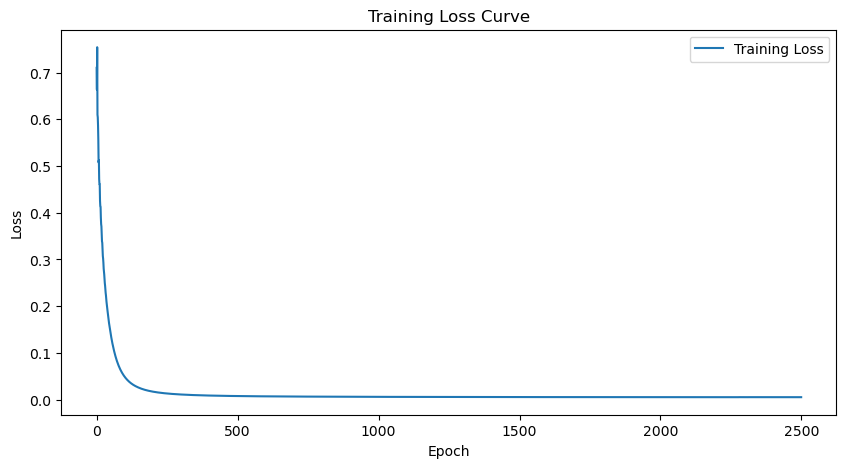

Final Model Accuracy: 75.79%
Final Model F1-score: 0.7677


: 

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 1

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))